# Data Challenge Project: Fraud Detection  

<img src="https://github.com/er1czz/kaggle/blob/master/unsplash_transaction.JPG?raw=true" align = "left" style = "border:10px solid white">  
Credit card fraud is a common financial fraud that using a payment card to proceed a transaction with illegitimate nature. Researchers specialized in fraud dection often encouter such challenge: how to maximaize the transaction security with minimal hassles to clients. With the recent advance in machine learning and computation technology, this challenge can be addressed by implementing high accuracy predictive models based on machine learning.       

<b>This project intends to develop a predicative model based on machine learning algorithms of binary classification.</b> The goal is to maximize the detection rate of fradulent activities while minimizing the number of false alarms (false positive events). Data are kindly provided by [Kaggle.com](https://www.kaggle.com/c/ieee-fraud-detection), which consist of two datasets: identity and transaction.

<b>The project consists of five sections as follows:
1. Data exploration
2. Data splitting
3. Feature selection
4. Models training and testing
5. Summary</b>

In [1]:
cd ../../../../Desktop/Fraud2/

C:\Users\EzzZ\Desktop\Fraud2


In [2]:
import pandas as pd

In [3]:
id = pd.read_csv('train_identity.csv')
tn = pd.read_csv('train_transaction.csv')

## 1. Data exploration

In [4]:
print(id.shape)
print(tn.shape)

(144233, 41)
(590540, 394)


In [5]:
id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
tn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Feature "TransactionDT" is timedelta from a given reference datetime (not an actual timestamp).

In [7]:
id.isnull().sum().max()

139486

In [8]:
tn.isnull().sum().max()

552913

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### 1.1. Remove unpaired transaction (mismatch between identity and transaction datasets)

In [10]:
data = tn.merge(id, on= 'TransactionID', copy = False)

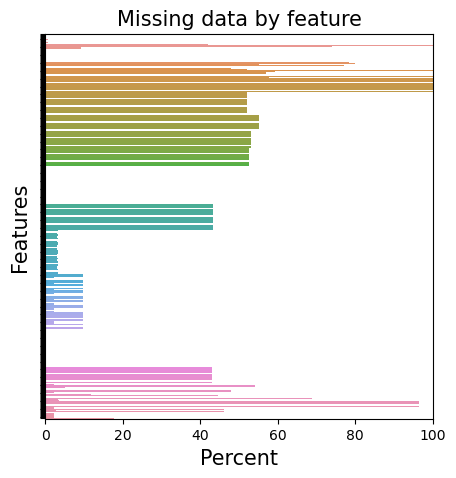

In [11]:
plt.style.use('default')
total=data.isnull().sum()
percent=data.isnull().sum()/data.isnull().count()*100
missing_data=pd.concat([total,percent],axis=1, keys=['total', 'percent'])

plt.subplots(figsize=(5, 5))
g = sns.barplot(y=missing_data.index,x=missing_data['percent'])
g.set(yticklabels=[])

plt.xlim(0, 100)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Percent', fontsize=15)
plt.title('Missing data by feature', fontsize=15)
plt.show()

In [12]:
missing = data.isnull().sum().sum()
total = data.size
percent = missing/total*100
print('Missing data entry %.f' % missing)
print('Total data entry   %.f' % total)
print('Missing data:      %.2f%%\n' % percent)

tmp1 = data.isnull().any(axis = 0).sum()
print('Columns with missing values %.f' %tmp1)
print('total columns               %.f' %len(data.columns))

tmp2 = data.isnull().any(axis = 1).sum()
print('Rows with missing values %.f' %tmp2)
print('total rows               %.f' %len(data))

Missing data entry 16834880
Total data entry   62597122
Missing data:      26.89%

Columns with missing values 412
total columns               434
Rows with missing values 144233
total rows               144233


# 2. Data splitting

### Treating missing value is tricky for data pre-processing. 
- Each row has missing value. A few columns have more than 50% data of missing values. Total missing data in percentage is 26.9%.
- Features with over 90% data of missing values will be discarded. For the rest, the missing values will be replaced with mean.
- Considering the potential data leakage, the data jettison will be performed first, splitting data second, and replacing missing values last.

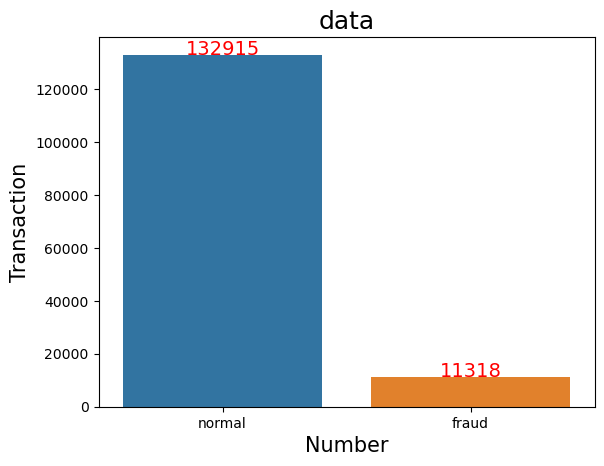

In [13]:
import numpy as np
sns.countplot(x='isFraud',data=data)
plt.xticks( np.arange(2), ['normal', 'fraud'] )
plt.title('data',fontsize= 18)
plt.xlabel('Number',fontsize = 15)
plt.ylabel('Transaction',fontsize = 15)
labels = (data['isFraud'].value_counts())
for i, v in enumerate(labels):
    plt.text(i, v, str(v), ha = 'center', size = 14, color = 'r')
plt.show()

### 2.1. Remove columns with over 90% data missing 

In [14]:
data_1 = data.dropna(axis=1, thresh=len(data)*0.1)

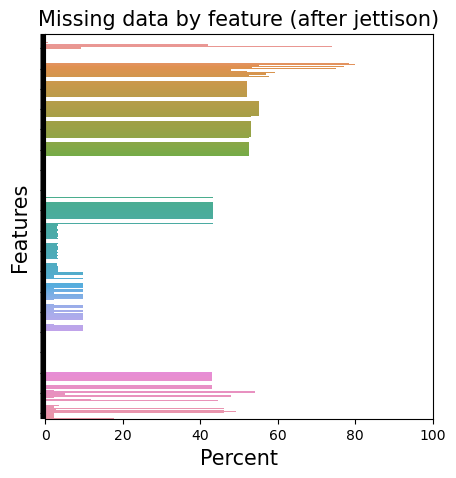

In [15]:
plt.style.use('default')
total1=data_1.isnull().sum()
percent1=data_1.isnull().sum()/data_1.isnull().count()*100
missing_data1=pd.concat([total1,percent1],axis=1, keys=['total', 'percent'])

plt.subplots(figsize=(5, 5))
g = sns.barplot(y=missing_data1.index,x=missing_data1['percent'])
g.set(yticklabels=[])

plt.ylabel('Features', fontsize=15)
plt.xlabel('Percent', fontsize=15)
plt.xlim(0, 100)
plt.title('Missing data by feature (after jettison)', fontsize=15)
plt.show()

In [16]:
tmp = data_1.size/data.size*100
print('Data preserved: %.2f%%\n' % tmp)

Data preserved: 93.09%



### 2.2. Splitting data: 80% for training and 20% for testing

In [17]:
X = data_1.drop('isFraud', axis=1)
y = data_1['isFraud'].copy()

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [19]:
tmp = y_test.sum(axis=0)/y.sum(axis=0)*100
print('Testing data: %.1f%%\n' % tmp)

Testing data: 20.5%



In [20]:
y_train.head()

122872    0
54800     0
109241    1
5569      0
1874      0
Name: isFraud, dtype: int64

##### Manually split the dataset for the convenience of data wrangling

In [21]:
normal = data_1[data_1['isFraud'] == 0]
fraud = data_1[data_1['isFraud'] == 1]
# shuffle
normal_r = normal.sample(frac=1)
fraud_r = fraud.sample(frac=1)
# 80% for training and 20% for testing.
normal_1 = normal_r[:106332]
normal_2 = normal_r[106333:]
fraud_1 = fraud_r[:9054]
fraud_2 = fraud_r[9055:]
train = pd.concat([normal_1, fraud_1])
test = pd.concat([normal_2, fraud_2])

### Double check the data features

In [22]:
print(train.shape)
print(test.shape)

(115386, 404)
(28845, 404)


In [23]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
6300,3011327,0,612890,25.000,H,10625,583.0,150.0,mastercard,219.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device
122380,3471063,0,12596865,50.000,H,17400,174.0,150.0,visa,226.0,...,mobile safari generic,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
82026,3252764,0,6443699,26.464,C,7255,545.0,185.0,visa,195.0,...,chrome 64.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
126135,3493180,0,13267628,150.000,R,14426,111.0,150.0,mastercard,224.0,...,edge 15.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
12426,3027413,0,1003211,25.000,H,6170,174.0,150.0,visa,226.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,MacOS


In [24]:
train[['card4','id_31','DeviceType','DeviceInfo']]

,card4,id_31,DeviceType,DeviceInfo
6300,mastercard,mobile safari 11.0,mobile,iOS Device
122380,visa,mobile safari generic,mobile,iOS Device
82026,visa,chrome 64.0,desktop,Windows
126135,mastercard,edge 15.0,desktop,Windows
12426,visa,chrome 62.0,desktop,MacOS
...,...,...,...,...
14016,mastercard,chrome 62.0 for android,mobile,WAS-LX3 Build/HUAWEIWAS-LX3
56184,mastercard,chrome 63.0,desktop,Windows
111144,visa,safari generic,desktop,MacOS
56273,mastercard,chrome 62.0,mobile,NaN


### 2.3. Replacing missing value with mean

In [25]:
train_m = train.fillna(train.mean())

In [26]:
train_m.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
6300,3011327,0,612890,25.000,H,10625,583.0,150.0,mastercard,219.0,...,mobile safari 11.0,32.000000,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device
122380,3471063,0,12596865,50.000,H,17400,174.0,150.0,visa,226.0,...,mobile safari generic,32.000000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
82026,3252764,0,6443699,26.464,C,7255,545.0,185.0,visa,195.0,...,chrome 64.0,26.504259,NaN,NaN,F,F,T,F,desktop,Windows
126135,3493180,0,13267628,150.000,R,14426,111.0,150.0,mastercard,224.0,...,edge 15.0,24.000000,1366x768,match_status:2,T,F,T,T,desktop,Windows
12426,3027413,0,1003211,25.000,H,6170,174.0,150.0,visa,226.0,...,chrome 62.0,24.000000,1366x768,match_status:2,T,F,T,T,desktop,MacOS


In [27]:
test_m = test.fillna(test.mean())

## 3. Feature Selection

### 3.1. Use encoder: non-numerical value --- > numberical value

In [28]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [29]:
for f in train_m.columns:
    if train_m[f].dtype=='object': 
        le = preprocessing.LabelEncoder()
        le.fit(list(train_m[f].values))
        train_m[f] = le.transform(list(train_m[f].values))

In [30]:
train_m[['card4','id_31','DeviceType','DeviceInfo']]

,card4,id_31,DeviceType,DeviceInfo
6300,2,93,1,1642
122380,4,96,1,1642
82026,4,49,0,1517
126135,2,68,0,1517
12426,4,43,0,675
...,...,...,...,...
14016,2,44,1,1512
56184,2,46,0,1517
111144,4,112,0,675
56273,2,43,1,1656


In [31]:
test[['card4','id_31','DeviceType','DeviceInfo']]

,card4,id_31,DeviceType,DeviceInfo
17335,visa,chrome 63.0,desktop,Windows
45962,visa,firefox 57.0,desktop,Windows
113391,mastercard,chrome 65.0 for android,mobile,HTCD100LVWPP
35793,visa,firefox 57.0,desktop,rv:57.0
107101,mastercard,safari generic,desktop,NaN
...,...,...,...,...
126356,visa,chrome generic,desktop,Windows
22454,mastercard,mobile safari generic,mobile,NaN
89419,discover,mobile safari generic,mobile,iOS Device
82825,mastercard,mobile safari generic,mobile,iOS Device


In [32]:
for f in test_m.columns:
    if test_m[f].dtype=='object': 
        le = preprocessing.LabelEncoder()
        le.fit(list(test_m[f].values))
        test_m[f] = le.transform(list(test_m[f].values))

In [33]:
test_m[['card4','id_31','DeviceType','DeviceInfo']]

,card4,id_31,DeviceType,DeviceInfo
17335,4,39,0,952
45962,4,69,0,952
113391,2,46,1,211
35793,4,69,0,1062
107101,2,106,0,1039
...,...,...,...,...
126356,4,53,0,952
22454,2,90,1,1039
89419,1,90,1,1027
82825,2,90,1,1027


### 3.2. Correlation

In [34]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
6300,3011327,0,612890,25.000,H,10625,583.0,150.0,mastercard,219.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device
122380,3471063,0,12596865,50.000,H,17400,174.0,150.0,visa,226.0,...,mobile safari generic,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
82026,3252764,0,6443699,26.464,C,7255,545.0,185.0,visa,195.0,...,chrome 64.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
126135,3493180,0,13267628,150.000,R,14426,111.0,150.0,mastercard,224.0,...,edge 15.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
12426,3027413,0,1003211,25.000,H,6170,174.0,150.0,visa,226.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,MacOS


In [52]:
train_c = train.set_index('TransactionID')

In [59]:
print(train_c.shape)

(115386, 403)


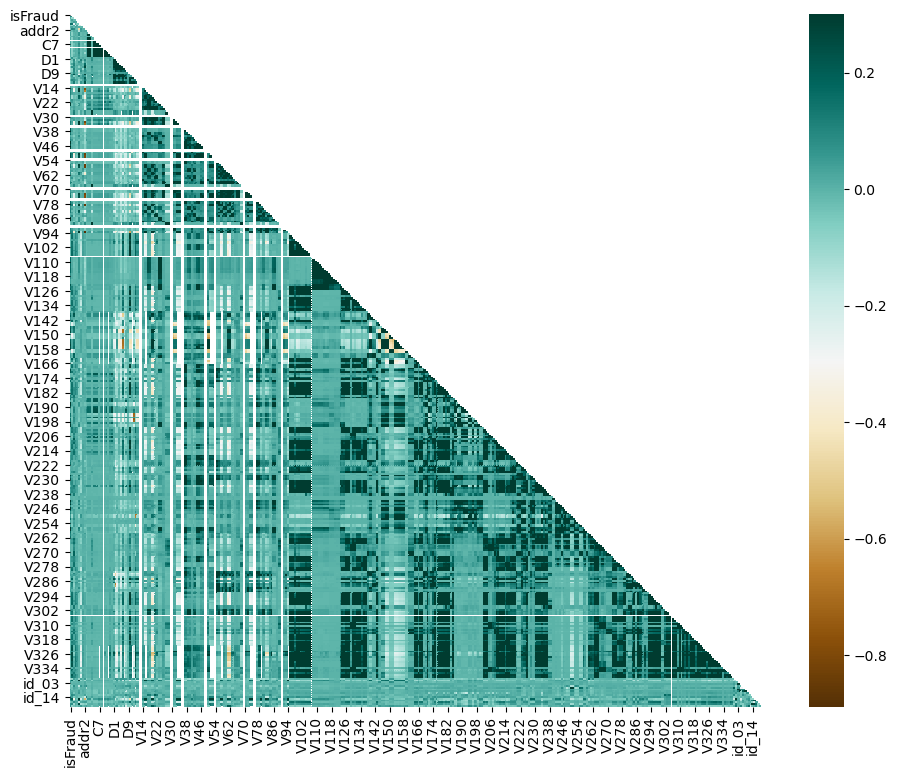

In [67]:
correlation_matrix = train_c.corr()
plt.figure(figsize=(12,9))
matrix = np.triu(train_c.corr())
sns.heatmap(correlation_matrix, mask = matrix, vmax=.3, square=True, cmap= 'BrBG')

- <span style="color:blue;">There is no feature exhibiting noticeable correlation with "isFraud".</span>  
- Feature category C and V series show noticeable intercorrelations. Due to the lack of feature information, additional feature analysis is not carried out. 

### 3.3. Data balancing (undersample)

#### The training dataset is highly skewed. 
- The fraction of fradulent transactions is a minority, compared to that of normal ones. 
- Thus, accurate correlations between the fraudulent transactions and their corresponding features can be challenging. 
- To overcome this issue, undersampling the majority (normal) is performed which can help to balance the dataset and to improve the computation efficiency.

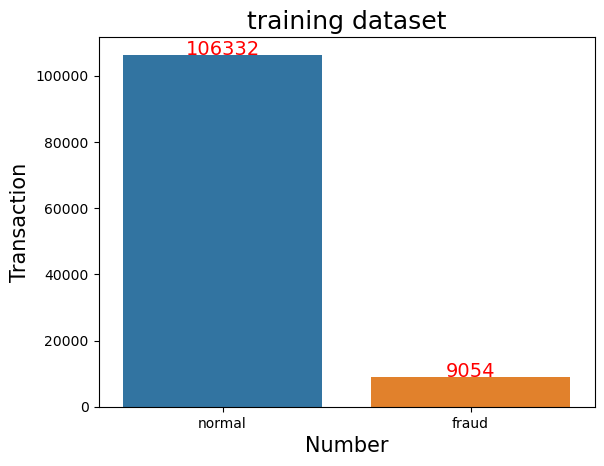

In [36]:
sns.countplot(x='isFraud',data=train_m)
plt.xticks( np.arange(2), ['normal', 'fraud'] )
plt.title('training dataset',fontsize= 18)
plt.xlabel('Number',fontsize = 15)
plt.ylabel('Transaction',fontsize = 15)
labels = (train_m['isFraud'].value_counts())
for i, v in enumerate(labels):
    plt.text(i, v, str(v), ha = 'center', size = 14, color = 'r')
plt.show()

In [37]:
normal_m = train_m[train_m['isFraud'] == 0]
fraud_m = train_m[train_m['isFraud'] == 1]

normal_mr = normal_m.sample(frac=1) 
normal_u = normal_mr[:9054]
train_u = pd.concat([normal_u, fraud_m])

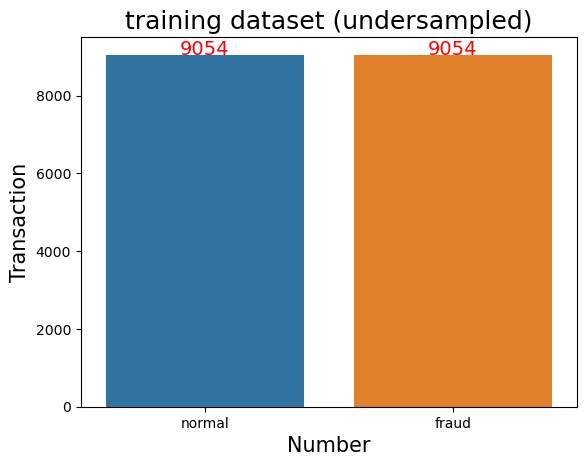

In [38]:
sns.countplot(x='isFraud',data=train_u)
plt.xticks( np.arange(2), ['normal', 'fraud'] )
plt.title('training dataset (undersampled)',fontsize= 18)
plt.xlabel('Number',fontsize = 15)
plt.ylabel('Transaction',fontsize = 15)
labels = (train_u['isFraud'].value_counts())
for i, v in enumerate(labels):
    plt.text(i, v, str(v), ha = 'center', size = 14, color = 'r')
plt.show()

## 4. Model training and testing

In [39]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [40]:
X_train = train_u.drop('isFraud', axis=1)
y_train = train_u['isFraud'].copy()
X_test = test_m.drop('isFraud', axis=1)
y_test = test_m['isFraud'].copy()

### 4.1. Logistic

In [41]:
LR = LogisticRegression(C=1e5)
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)

### 4.2. XGBoost


In [42]:
XG = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist')
XG.fit(X_train, y_train)
XG_pred = XG.predict(X_test)

### 4.3. Random Forest

In [43]:
RF = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)
RF.fit(X_train, y_train)
RF_pred = RF.predict(X_test)

### 4.4. Validation metrics

#### F<sub>1</sub> score

In [44]:
score1 = metrics.f1_score(y_test, LR_pred)
score2 = metrics.f1_score(y_test, XG_pred)
score3 = metrics.f1_score(y_test, RF_pred)
print ('Logistic F1 score:     %.5f' % score1 )
print ('XGboost F1 score:      %.5f' % score2 )
print ('RandomForest F1 score: %.5f' % score3 )

Logistic F1 score:     0.28053
XGboost F1 score:      0.69675
RandomForest F1 score: 0.44356


#### Fitting

In [45]:
LR_fit = LR.predict(X_train)
XG_fit = XG.predict(X_train)
RF_fit = RF.predict(X_train)

score4 = metrics.f1_score(y_train, LR_fit)
score5 = metrics.f1_score(y_train, XG_fit)
score6 = metrics.f1_score(y_train, RF_fit)

print ('Logistic fitting F1:     %.5f' % score4 )
print ('XGboos fitting F1:       %.5f' % score5 )
print ('RandomForest fitting F1: %.5f' % score6 )

Logistic fitting F1:     0.72179
XGboos fitting F1:       0.99740
RandomForest fitting F1: 0.76958


#### Comparing the prediction and fitting results:
- The XGboost model produced practical prediction with with F<sub>1</sub> score of 0.68.
- Neither the Logisitic model nor the Random Forest model yielded favorable results, which gave F<sub>1</sub> scores of 0.29 and 0.45, respectively.

## 5. Summary  
This project aimed to tackle the data challenge in fraud detection. The original data contain information of transaction and identification. Notably, the data are heavily skewed: 96.5% of transactions is non-fradulent. In addition, the dataset contain missing values and categorical features. To overcome these challenges, undersampling was performed to balance the data; features with missing data were either discarded or replaced by means; all the non-numberical features were systematically transformed into numberical by encoder. To validate model predictivity, original dataset was randomlly splited into two groups: 80% for training and 20% for testing. Three models based on Logistic, XGboost, and Random Forest classifications were developed and tested, which yielded F<sub>1</sub> scores of 0.29, 0.68, and 0.45, respectively. This data challenge project suggests that machine learning model has potential to provide high accuracy fraud detection, especially by using the XGboost algorithm.

### Future tasks
1. Feature engineering and selection: Reduce data redundancy and improve the data quality.
2. Model optimization: Hyperparameters in XGBoost and L1 L2 regularization for Logistic regression.
3. Additional metrics: Because F<sub>1</sub> score does not take true negative into account, other metrics for evaluationg binary classification such as precision-recall AUC curve and confusion matrix will be exercised.
4. Others: PCA analysis, data normalization (scaler), learning curve, LightGBM, etc.

### References  
https://www.kdnuggets.com/2020/07/easy-guide-data-preprocessing-python.html  
https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets  
https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis  
https://www.kaggle.com/shahules/tackling-class-imbalance  
https://scikit-learn.org/   
https://en.wikipedia.org/wiki/F1_score

Image source  
https://images.unsplash.com/photo-1563013544-824ae1b704d3